# Load data and functions

For this tutorial, we use the processed Mouse protein data by *Abid et al. 2018, Nature Communications*. We let the shock therapy received mice as the target dataset and the mice without the therapy as the candidate background dataset. As for the users, we recommend to replace the directory name '/storage10/kwangmoon/BasCoD/' with the name of the directory where the BasCoD was installed.

In [1]:
source('/storage10/kwangmoon/BasCoD/Rcodes/functions/BasCoD.R')
setwd('/storage10/kwangmoon/BasCoD/data')
target=readRDS("Mouse_DS_target.rds")
background=readRDS("Mouse_DS_background.rds")
lab=readRDS("Mouse_DS_label.rds")

### scale data

In [2]:
X_0=target
X_0[is.na(X_0)]=0
X_0=scale(X_0)

X_j=background
X_j[is.na(X_j)]=0
X_j=scale(X_j)
X_j_list=list(X_j)

# Implement PCA for each of the target and background dataset

In [3]:
prc_0=prcomp(X_0)
prc_j=prcomp(X_j)
embedding_0=prc_0$x
embedding_j=prc_j$x

### Eigenvalue scree plot for each dataset and the rank decision with elbow points.

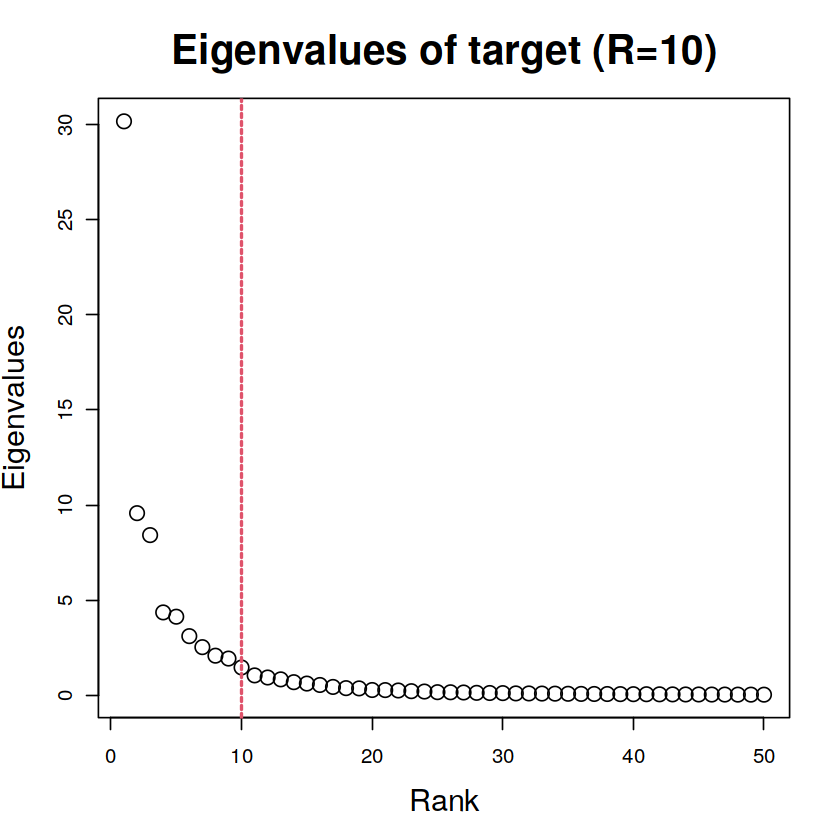

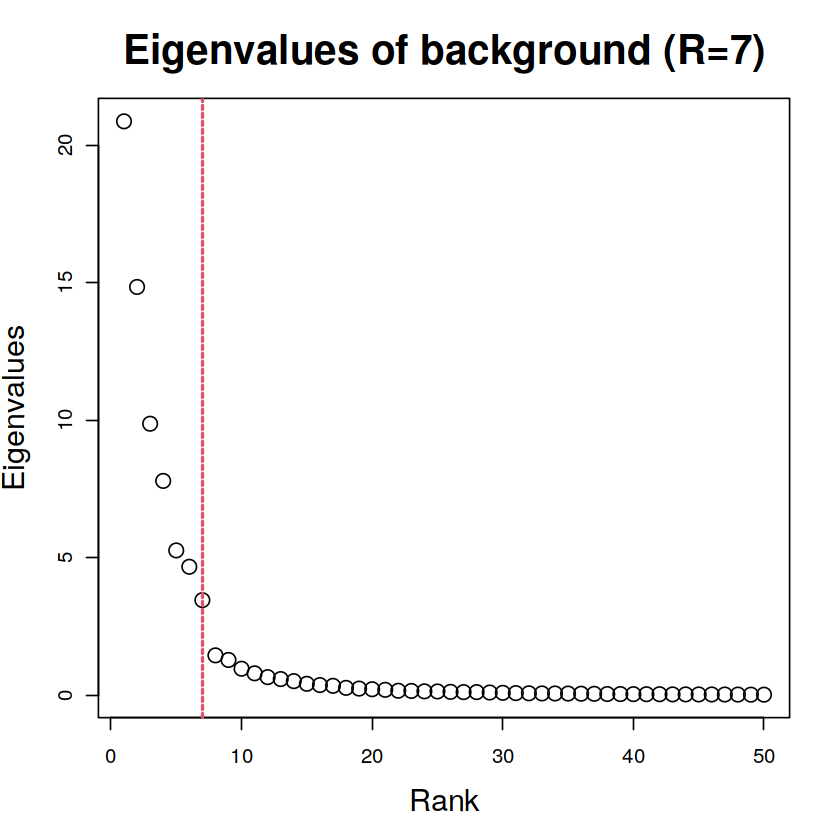

In [4]:
options(repr.plot.width=7, repr.plot.height=7)
plot((prc_0$sdev[1:50]^2),cex=1.5,cex.lab =1.5,cex.main =2,main="Eigenvalues of target (R=10)",xlab="Rank",ylab="Eigenvalues")
    abline(v=10,col=2,lty=2,lwd=2)


plot((prc_j$sdev[1:50]^2),cex=1.5,cex.lab =1.5,cex.main =2,main="Eigenvalues of background (R=7)",xlab="Rank",ylab="Eigenvalues")
    abline(v=7,col=2,lty=2,lwd=2)


# Apply BasCoD

BasCoD function requires the following inputs:

1. **X_0**: Target dataset with matrix format. 
2. **X_j_list**: List of candidate background datasets with the form of R list, whose each entry corresponds to a matrix specific to a candidate background dataset.
3. **R_0**: Rank of the target dataset. 
4. **R_j_list**: List of ranks for the candidate background datasets.
5. **embedding_0**: Low dimensional embedding for the target dataset. 
6. **embedding_j_list**: List of low dimensional embedding for the candidate background datasets. 
7. **eps**: Slack parameter $\epsilon$. The default is set as $\epsilon=0.3$.



In [5]:
bascod_res=BasCoD_single(X_0=X_0,X_j=X_j,R_0=10,R_j = 7,embedding_0=embedding_0,embedding_j = embedding_j,eps=0.3)

[1] "BasCoD p-value is : 0.16884145399348"


The BasCoD procedure provides $\mbox{p-value}=0.16>0.05$, which indicates that the non-treated mice can be used as a valid background with for a contrastive PCA. 

# Implementation of cPCA and visualization

### Now, with the valid background dataset, we apply cPCA (Abid et al. 2018) to the mouse protein dataset.

Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



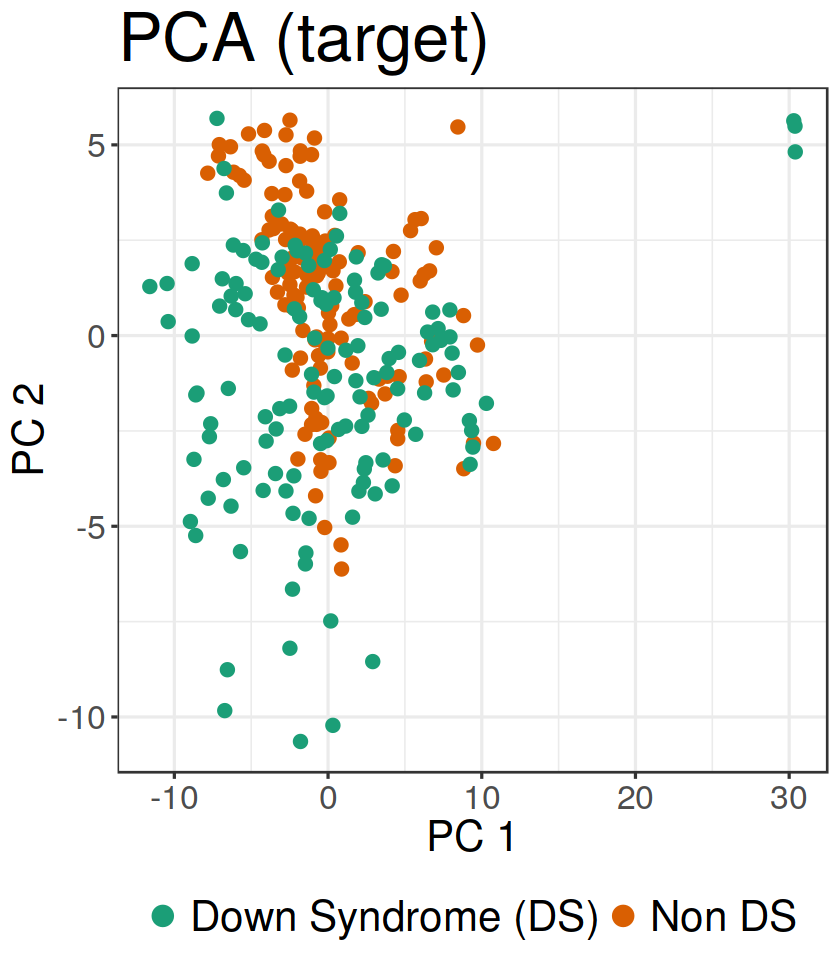

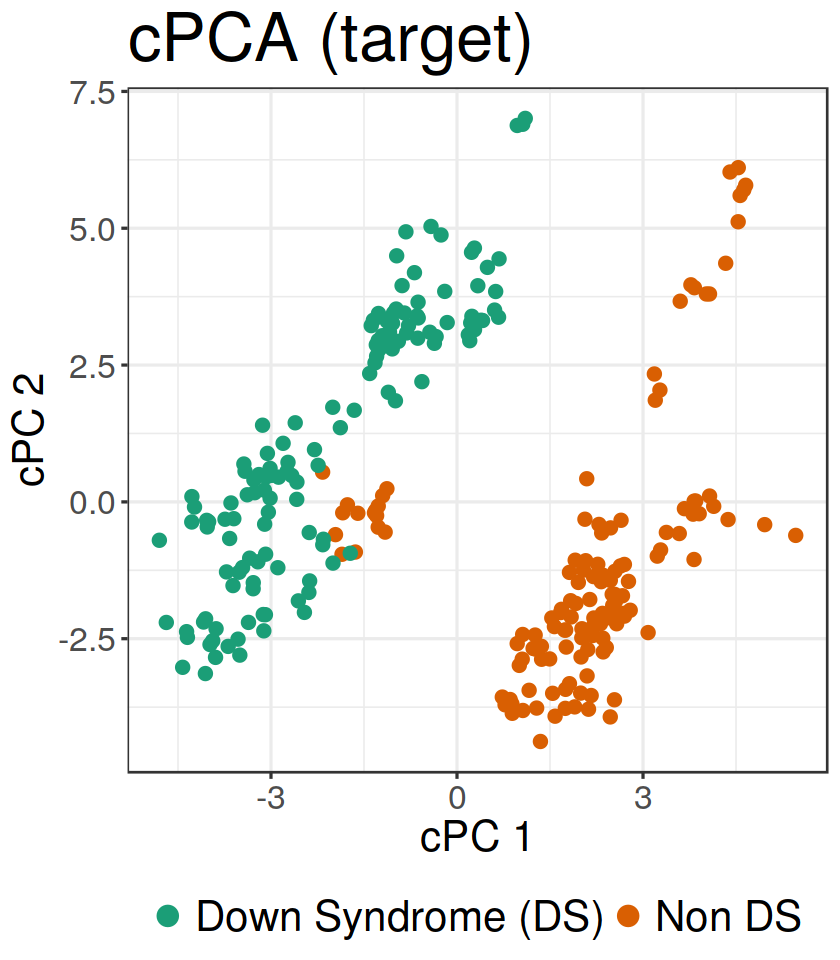

In [6]:
library(ggplot2)
library(RColorBrewer)
library(mclust)

options(repr.plot.width=7, repr.plot.height=8)

colsch="Dark2"

cov_0=cov(X_0)
cov_j=cov(X_j)

for(alpha in c(0,10)) {
  cprc_res=eigen(cov_0-alpha*cov_j)
  cPC=X_0%*%cprc_res$vectors[,1:2]
  
  if(alpha==0){
    
    tmp = data.frame(cPC[,1:2])
    colnames(tmp) = c("X1", "X2")
    p=ggplot(tmp, aes(x = X1, y = X2))+ labs(color = "")  + ylab("PC 2") +
      xlab("PC 1") + theme_bw(base_size = 15)+ggtitle(paste0("PCA (target)")) +
      geom_point(aes(color = lab),size=3)+ guides(colour = guide_legend(override.aes = list(size=3)))+
      theme(legend.position = "bottom",legend.text = element_text(size=25),legend.title=element_blank(),
            plot.title=element_text(size=40),axis.title=element_text(size=25),
            axis.text=element_text(size=20))+
      scale_color_brewer(palette = colsch) + 
      guides(colour = guide_legend(override.aes = list(size = 5),nrow=1,ncol=2))
    print(p)    
    
    
    cluster=lab
    set.seed(1)
    kmeans_cluster=kmeans(cPC[,1:2],2)$cluster
    ARI_val_PCA=adjustedRandIndex(kmeans_cluster,cluster )
    
    
    
  }
  if(alpha!=0){
    tmp = data.frame(cPC[,1:2])
    colnames(tmp) = c("X1", "X2")
    p=ggplot(tmp, aes(x = X1, y = X2))+ labs(color = "")  + ylab("cPC 2") +
      xlab("cPC 1") + theme_bw(base_size = 15)+ggtitle(paste0("cPCA (target)")) +
      geom_point(aes(color = lab),size=3)+ guides(colour = guide_legend(override.aes = list(size=3)))+
      theme(legend.position = "bottom",legend.text = element_text(size=25),legend.title=element_blank(),
            plot.title=element_text(size=40),axis.title=element_text(size=25),
            axis.text=element_text(size=20))+
      scale_color_brewer(palette = colsch) + 
      guides(colour = guide_legend(override.aes = list(size = 5),nrow=1,ncol=2))
    print(p)
    
    
    cluster=lab
    set.seed(1)
    kmeans_cluster=kmeans(cPC[,1:2],2)$cluster
    ARI_val_cPCA=adjustedRandIndex(kmeans_cluster,cluster )
    
    
  }    
  
  
}

It turns out that the cPCA on the target data provides a much clearer separation (ARI=0.79) between DS and Non DS mice than that of the PCA (ARI=0.009).